In [1]:
# Core imports
import heyoka as hk
import pykep as pk
import numpy as np
from numpy import linalg as la
import pandas as pd
import math
from numpy.lib.function_base import append
# Sys imports
import time
# Plot imports
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
# Other imports
from UROP_const import *
from UROP_aux_func import *

In [2]:
#create heyoka variables
X,Y,Z = hk.make_vars("X","Y","Z")
VX,VY,VZ = hk.make_vars("VX","VY","VZ")

In [3]:
# Step 1: Define Initial Conditions (dimensional)
r0 = np.array([0.0, -5888.9727, -3400.0]) #km   (class 'numpy.ndarray')
v0 = np.array([10.691338, 0.0, 0.0])      #km/s
[a0, e0_norm, i0, RAAN0, omega0, theta0] = rv2elorb(r0, v0, GMe)

In [4]:
# Step 2: non-dimensionalise the ICs
r0nd = r0 / a0 #[km/km] = [-] since the orbit is highly elliptical normalise with the initial semimajor axis
               # otherwise use r0nd = r0/la.norm(r0)
v0nd = v0 * math.sqrt(a0/GMe)    #[-]
t0   = 0                         #s
t0nd = t0 / math.sqrt((a0**3)/GMe) #[-]

In [5]:
# Non-dimensional ICs
S0 = [*r0nd, *v0nd]
# print(S0)

In [6]:
# Non-dimensionalise the parameters
GMend = 1 # GMe * a0d / (a0d * GMe) 
Rend  = Re / a0
rlnd  = rl / a0
omega_lnd = omega_l * math.sqrt((a0**3)/GMe)
GMlnd = GMl / GMe

In [7]:
# Final time
# Test - based on 50 orbits
# T = 2*np.pi * np.sqrt(a0**3/GMe)  # orbital period
# print(f'the orbital period is {T/(24*3600)} days for one orbit')
# n_orb = 50
# tf = T * n_orb
tf = 288.12768941*24*3600 #actual
tfnd  = tf / math.sqrt((a0**3)/GMe)          #[-]  (2*np.pi * 50:roughly 50 orbits)
delta_t = 500                                # s (max time beween consecutive integration points)
delta_tnd  = delta_t / math.sqrt((a0**3)/GMe)          #[-]
N = math.floor((tfnd-t0nd)/delta_tnd - 1)

In [32]:
#Earth's Keplerian terms
magR2 = X**2 + Y**2 + Z**2
r = (magR2)**(1/2)
fKepX = -X/(magR2**(3./2))
fKepY = -Y/(magR2**(3./2))
fKepZ = -Z/(magR2**(3./2))

#Earth's J2 terms
fJ2X = ( (3/2)*J2*Rend**2/r**4 ) * (X/r)*(5*(Z**2/r**2) -1)
fJ2Y = ( (3/2)*J2*Rend**2/r**4 ) * (Y/r)*(5*(Z**2/r**2) -1)
fJ2Z = ( (3/2)*J2*Rend**2/r**4 ) * (Z/r)*(5*(Z**2/r**2) -3)

# Third body (moon)
r3 = np.array([ rlnd * hk.sin(omega_lnd*hk.time),
                rlnd * (- (math.sqrt(3)*hk.cos(omega_lnd*hk.time))/2) ,
                rlnd * (- hk.cos(omega_lnd*hk.time)/2)])
r3_norm  = (r3[0]**2 + r3[1]**2 + r3[2]**2)**(1/2)
r3r      = r3 - np.array([X, Y, Z])
r3r_norm = (r3r[0]**2 + r3r[1]**2 + r3r[2]**2)**(1/2)

fLX = GMlnd * ( (r3[0] - X)/(r3r_norm**3) - r3[0]/(r3_norm**3) )
fLY = GMlnd * ( (r3[1] - Y)/(r3r_norm**3) - r3[1]/(r3_norm**3) )
fLZ = GMlnd * ( (r3[2] - Z)/(r3r_norm**3) - r3[2]/(r3_norm**3) )


In [33]:
#EOMs
dXdt = VX
dYdt = VY
dZdt = VZ
dVXdt = fKepX + fJ2X + fLX 
dVYdt = fKepY + fJ2Y + fLY 
dVZdt = fKepZ + fJ2Z + fLZ

In [34]:
ic = S0
print('Compiling the Taylor integrator ... (this is done only once)')
start_time = time.time()

ta = hk.taylor_adaptive(sys = [(X,dXdt),(Y,dYdt),(Z,dZdt),(VX,dVXdt),(VY,dVYdt),(VZ,dVZdt)],
                        state = ic,
                        time = t0nd,
                        tol = 1e-16,
                        compact_mode = True)
end_time = time.time()

print('Done, in');
print("--- %s seconds ---" % (end_time - start_time))

print("\nHeyoka Taylor integrator:\n", ta)

Compiling the Taylor integrator ... (this is done only once)
Done, in
--- 0.7444641590118408 seconds ---

Heyoka Taylor integrator:
 Taylor order            : 20
Dimension               : 6
Time                    : 0.0000000000000000
State                   : [0.0000000000000000, -0.043301136620257551, -0.024999923078073649, 6.2450078709673145, 0.0000000000000000, 0.0000000000000000]



In [35]:
# How often to log the state
# delta_tnd

# Here we redefine the initial conditions since we may want to change them without recompiling the integrator
ta.time = t0
# Note the python syntax to assign directly the array elements. Here necessary
# as heyoka does not allow to change the memory location of the state
ta.state[:] =  S0

In [36]:
t_span = np.linspace(t0nd, tfnd, N, endpoint = True)
print(np.shape(t_span))

(49787,)


In [37]:
start_time = time.time()
out = ta.propagate_grid(t_span)
end_time = time.time()

print('Done, in');
print("--- %s seconds ---" % (end_time - start_time))
St = out[4] 
size = np.shape(St)
print(f'the shape of the solution (cartesian form) is {size}')

Done, in
--- 0.05111813545227051 seconds ---
the shape of the solution (cartesian form) is (49787, 6)


In [38]:
rnd = St[:, :3]
vnd = St[:, -3:]
dim1, dim2 = np.shape(St)
print(dim1, dim2)

49787 6


In [39]:
# Dimensionalise the output state
r = np.empty((dim1, 3))
v = np.empty((dim1, 3))
for row in range(dim1):
    r[row, :] = rnd[row, :] * a0
    v[row, :] = vnd[row, :] / math.sqrt(a0/GMe)
print(r[-1], v[-1])

# [-24219.05011568 227962.10637287 129753.4424    ]
# [-0.30724447  0.15395021  0.07809787]  from hk

# [-24219.04959873 227962.10611906 129753.4422715 ]
# [-0.30724447  0.15395021  0.07809787] from solve ivp

[-24219.05011568 227962.10637287 129753.4424    ] [-0.30724447  0.15395021  0.07809787]


In [41]:
t_days = np.empty((dim1, 1))
for t, i in zip(t_span, range(dim1)):
    t_days[i, 0] = ( t*math.sqrt((a0**3)/GMe) )/(24*3600)
    
print(t_days[-1]) # 288.8532812 (same as odeint)

[288.12768941]


In [42]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

              x            y            z
0      0.000000 -5888.972700 -3400.000000
1   5099.259765 -5036.927469 -2906.756458
2   9213.874031 -3082.960647 -1776.101622
3  12383.240467  -768.308755  -437.268680
4  14898.152155  1601.447785   933.083643


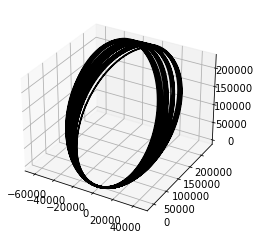

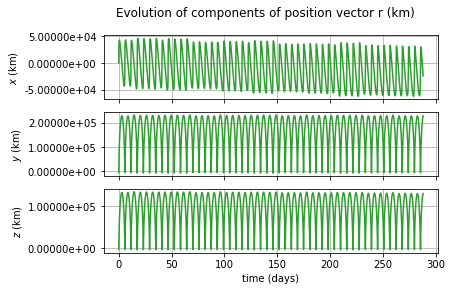

In [43]:
df_pos = pd.DataFrame(r, columns=["x", "y", "z"])
print(df_pos.head())

    
ax = plt.axes(projection='3d')
ax.plot3D(df_pos["x"], df_pos["y"], df_pos["y"], color = 'k', label = 'orbit')
ax.set_aspect('auto')
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
fig.suptitle(r'Evolution of components of position vector r (km)')
ax1.plot(t_days, df_pos["x"], 'tab:green')
ax1.set(ylabel=r"$x$ (km)")
ax2.plot(t_days, df_pos["y"], 'tab:green')
ax2.set(ylabel=r"$y$ (km)")
ax3.plot(t_days, df_pos["z"], 'tab:green')
ax3.set(xlabel=r"time (days)", ylabel=r"$z$ (km)")
# Add a grid to subplots
ax1.grid()
ax2.grid()
ax3.grid()
# Reformat the y axis notation
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5e'))
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5e'))
ax3.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.5e'))
set_axes_equal(ax)
plt.show()